## Introduction

##### In this project, flight data (ticket prices, dates, routes, duration and distance) of different airlines in the middle-east was obtained, analyzed and fitted to several regression models. 

#### Importing Libraries

In [63]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import iqr
import plotly.express as px
import pickle as pkl
sns.set()
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, Ridge, LinearRegression, ElasticNet, SGDRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.model_selection import GridSearchCV

#### Flight Distances for different routes

In [2]:
distance_dict = {'DMM-ELQ':601,'DMM-JED':1205,'DMM-MED':1036,'DMM-RAE':977,'DMM-RUH':354,'DMM-TIF':1091,'DMM-TUU':1315,
                 'DMM-YNB':1214,'DXB-AHB':2006,'DXB-DMM':573,'DXB-ELQ':1165,'DXB-JED':1700,'DXB-MED':1581,'DXB-RUH':870,
                 'DXB-TUU':1893,'IST-DMM':2534,'IST-ELQ':2160,'IST-JED':2382,'IST-MED':2115,'IST-RUH':2455,'IST-TIF':2428,
                 'IST-TUU':1566,'JED-AHB':528,'JED-AJF':903,'JED-AQI':1019,'JED-DMM':1205,'JED-ELQ':695,'JED-GIZ':641,
                 'JED-HAS':687,'JED-MED':325,'JED-RUH':852,'JED-TUU':784,'MED-RUH':709,'MNL-AHB':8305,'MNL-DMM':7461,
                 'MNL-ELQ':1166,'MNL-JED':8607,'MNL-MED':8171,'MNL-RUH':7788,'MNL-TUU':1616,'RUH-AHB':858,'RUH-AMM':1296,
                 'RUH-CAI':1614,'RUH-DAC':4408,'RUH-DMM':353.25,'RUH-DXB':875,'RUH-IST':2455,'RUH-JED':852,'RUH-MCT':1186,
                 'RUH-MED':709,'RUH-MNL':7788,'RUH-NYC':10500}

#### Read in data

In [3]:
# read in data
df = pd.read_csv('raw.csv')
df.head()

,Airline,Source,Destination,Duration,Total stops,Price,Date
0,SAUDIA,DMM,ELQ,12h 20m,1 stop,469 SAR,2022-06-01
1,SAUDIA,DMM,ELQ,4h 40m,1 stop,988 SAR,2022-06-01
2,SAUDIA,DMM,ELQ,12h 20m,1 stop,432 SAR,2022-06-01
3,SAUDIA,DMM,ELQ,7h 20m,1 stop,621 SAR,2022-06-01
4,SAUDIA,DMM,ELQ,5h 40m,1 stop,751 SAR,2022-06-01


#### Check for null values

In [4]:
df.isnull().sum()

Airline        0
Source         0
Destination    0
Duration       0
Total stops    0
Price          0
Date           0
dtype: int64

In [5]:
df.shape

(17507, 7)

#### Remove duplicates

In [6]:
df = df[df.duplicated(subset=None,keep='first') != True]

In [7]:
df.shape

(15148, 7)

#### Defining new functions for creating new columns and cleaning data

In [8]:
df['Route'] = df['Source'] + '-' + df['Destination']

# Functions for creating new columns; Feature Engineering
def distance(x):
    for key in list(distance_dict.keys()):
        if key == x:
            return distance_dict[key]
        
def price(x):
    return pd.to_numeric(x.split('\xa0')[0].replace(',',''))

def duration(x):
    hour = pd.to_numeric(x.split(' ')[0].replace('h',''))
    minute = pd.to_numeric(x.split(' ')[1].replace('m',''))
    return 60*hour+minute

def total_stops(x):
    if x != 'nonstop ':
        return int(x.split(' ')[0])
    else:
        return 0
        

def date(x):
    return pd.to_datetime(x)

def avg_price(airline):
    return df[df['Airline'] == airline]['price'].mean()


#### Apply new functions to dataset

In [9]:
df['flight_duration'] = df['Duration'].apply(duration)
df['total_stops'] = df['Total stops'].apply(total_stops)
df['distance'] = df['Route'].apply(distance)
df['price'] = df['Price'].apply(price)
df['average_price'] = df['Airline'].apply(avg_price)

In [739]:
df.head()

,Airline,Source,Destination,Duration,Total stops,Price,Date,Route,flight_duration,total_stops,distance,price,average_price
0,SAUDIA,DMM,ELQ,12h 20m,1 stop,469 SAR,2022-06-01,DMM-ELQ,740,1,601.0,469,1341.919464
1,SAUDIA,DMM,ELQ,4h 40m,1 stop,988 SAR,2022-06-01,DMM-ELQ,280,1,601.0,988,1341.919464
2,SAUDIA,DMM,ELQ,12h 20m,1 stop,432 SAR,2022-06-01,DMM-ELQ,740,1,601.0,432,1341.919464
3,SAUDIA,DMM,ELQ,7h 20m,1 stop,621 SAR,2022-06-01,DMM-ELQ,440,1,601.0,621,1341.919464
4,SAUDIA,DMM,ELQ,5h 40m,1 stop,751 SAR,2022-06-01,DMM-ELQ,340,1,601.0,751,1341.919464


#### Drop unwanted columns and save cleaned data

In [10]:

final_df = df.drop(['Airline','Route','Duration','Total stops','Price','Date'],axis=1)
# Saving cleaned dataset to local drive
final_df.to_csv('cleaned_data.csv',index=False)

#### Exploratory Data Analysis; we will explore the data to check for outliers as they could affect our model

In [14]:
num_columns = ['flight_duration','distance','price','average_price']

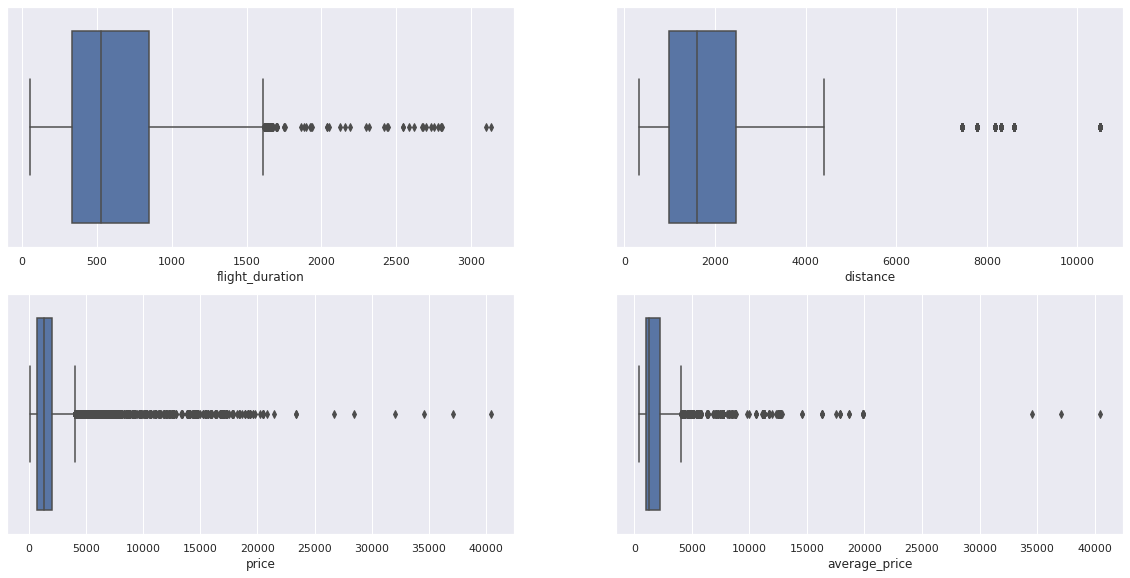

In [15]:
plt.figure(figsize=[20,15])
for i in range(0,len(num_columns)):
    plt.subplot(3,2,i+1)
    sns.boxplot(x=num_columns[i],data=df)
plt.savefig('data_with_outlier.png')

#### Remove outliers from numerical columns 

In [16]:
outlier_columns = ['flight_duration','distance','price','average_price']

In [28]:
# Removing the outliers for price
final_df = final_df[final_df['price'] < final_df['price'].quantile(0.75)+1.5*iqr(final_df['price'])]
# Removing the outliers for price
final_df = final_df[final_df['flight_duration'] < final_df['flight_duration'].quantile(0.75)+1.5*iqr(final_df['flight_duration'])]
# Removing outliers for flight_duration
final_df = final_df[final_df['distance'] < final_df['distance'].quantile(0.75)+1.5*iqr(final_df['distance'])]
# Removing outliers for flight_duration
final_df = final_df[final_df['average_price'] < final_df['average_price'].quantile(0.75)+1.5*iqr(final_df['average_price'])]

final_df.shape

(11120, 7)

#### Boxplots of numerical columns with outliers

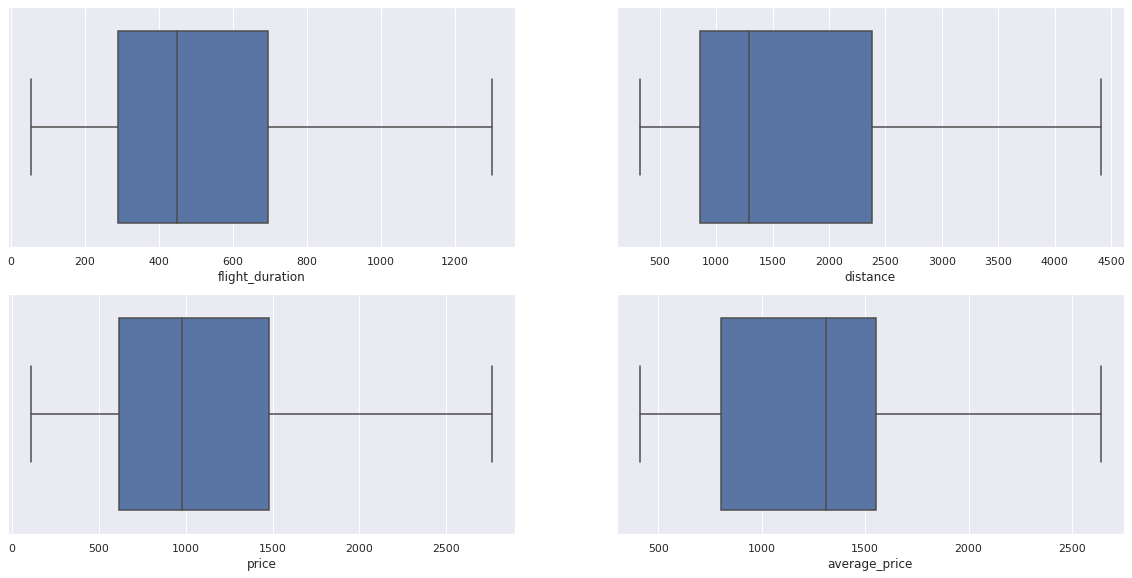

In [29]:
plt.figure(figsize=[20,15])
for i in range(0,len(num_columns)):
    plt.subplot(3,2,i+1)
    sns.boxplot(x=num_columns[i],data=final_df)
plt.savefig('data_without_outlier.png')

#### Correlation plots

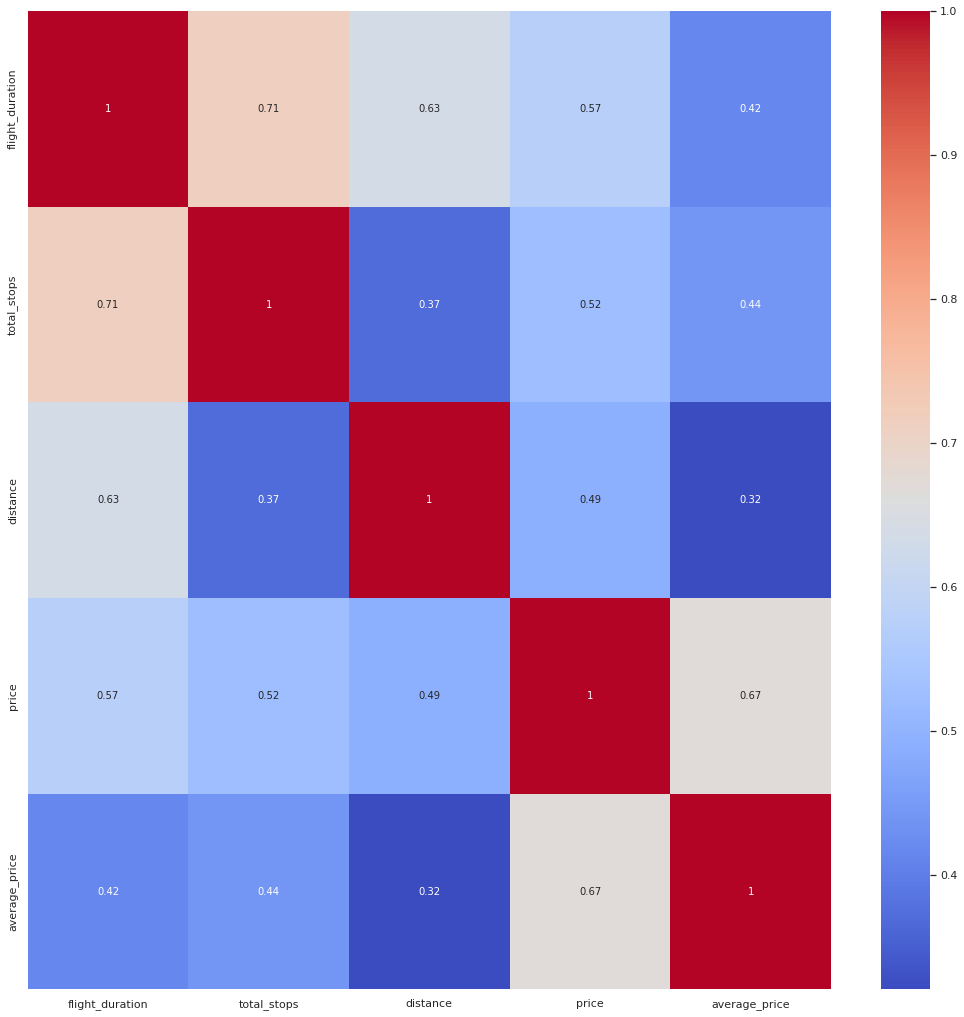

In [30]:
plt.figure(figsize = (18,18))

sns.heatmap(final_df.corr(),annot= True, cmap = "coolwarm")

plt.show()

#### Creating Features and Labels columns

In [43]:
df_copy = final_df.copy()

In [45]:
X = df_copy.drop('price',axis=1)
y = df_copy['price']

In [46]:
X.head()

,Source,Destination,flight_duration,total_stops,distance,average_price
0,DMM,ELQ,740,1,601.0,1311.056028
1,DMM,ELQ,280,1,601.0,1311.056028
2,DMM,ELQ,740,1,601.0,1311.056028
3,DMM,ELQ,440,1,601.0,1311.056028
4,DMM,ELQ,340,1,601.0,1311.056028


In [47]:
X_cat = X[['Source','Destination']]
X_num = X[['flight_duration','total_stops','distance','average_price']]

In [50]:
# Using StandardScaler to standardize numerical columns
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num.values)

In [51]:
# Using pd.get_dummies to convert catgerical columns
X_cat_convert = pd.get_dummies(X_cat)

In [53]:
# Joining numerical and categorical columns
X = np.c_[X_num_scaled,X_cat_convert.values]

In [60]:
# Making the new dataframe
X_new = pd.DataFrame(X,columns=['flight_duration','total_stops','distance','average_price']+list(X_cat_convert.columns))

#### Model Benchmarking

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2)

In [89]:
lr = LinearRegression()
sgd = SGDRegressor()
rf = RandomForestRegressor()
dtr = DecisionTreeRegressor()
xgb = GradientBoostingRegressor()
etr = ExtraTreesRegressor()
svr = SVR()
mlp = MLPRegressor()
eln = ElasticNet()

In [90]:
models = [lr,sgd,rf,dtr,xgb,etr,svr,mlp,eln]

In [91]:
def get_metrics(models):
    new = []
    for model in models:
        
        model.fit(X_train,y_train)
        score = cross_val_score(model, X_train, y_train, cv=5).mean().round(2)
        y_pred = model.predict(X_test)
        MAE = mean_absolute_error(y_pred,y_test).round(0)
        MSE = mean_squared_error(y_pred,y_test).round(0)
        RMSE = np.sqrt(mean_squared_error(y_pred,y_test)).round(0)
        new.append([score,MAE,MSE,RMSE])
    result = np.array(new)
    result = result.reshape(9,4)
    result = pd.DataFrame(result,columns=['score','MAE','MSE','RMSE'],index=['Linear Regression','SGDRegresor','Random Forest Regressor',
                                                                            'Decision Tree Regressor','Gradient Boosting Regressor',
                                                                             'ExtraTressRegressor','SVR','MLPRegressor','ElasticNet'])
    return result

In [92]:
final = get_metrics(models)
final

/home/uche/Desktop/interactive_dashboard/project/dashboard_venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/uche/Desktop/interactive_dashboard/project/dashboard_venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/uche/Desktop/interactive_dashboard/project/dashboard_venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/uche/Desktop/interactive_dashboard/project/dashboard_venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: Convergence

,score,MAE,MSE,RMSE
Linear Regression,0.64,253.0,115616.0,340.0
SGDRegresor,0.64,253.0,116246.0,341.0
Random Forest Regressor,0.83,146.0,55983.0,237.0
Decision Tree Regressor,0.79,152.0,61530.0,248.0
Gradient Boosting Regressor,0.74,207.0,83397.0,289.0
ExtraTressRegressor,0.81,148.0,59327.0,244.0
SVR,0.50,278.0,144053.0,380.0
MLPRegressor,0.65,246.0,110872.0,333.0
ElasticNet,0.57,283.0,134071.0,366.0


In [85]:
final.to_csv('final_result.csv')

#### Deduction; the metrics displayed on the final dataframe reveals that Random Forest Regressor and Extra Trees Regressor perform better than other regression models. Therefore, both models will be explored with Hyper-parameter tunning 

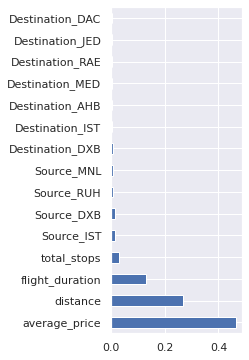

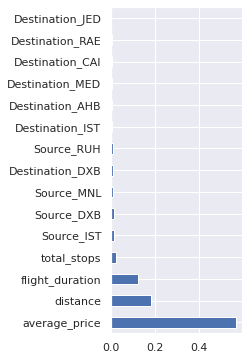

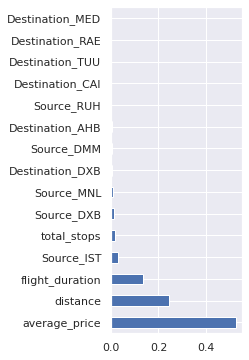

In [119]:
# plotting graph of important features for Random Forest, Decision Tree and Gradient Boosting regressors
visual_models = [rf,dtr,xgb]
plt.figure(figsize = (10,10))

for model in range(0,len(visual_models)):
    plt.subplot(1,3,i)
    visual_models[model].fit(X_train,y_train)
    feat_importances = pd.Series(visual_models[model].feature_importances_,index=X_new.columns)
    feat_importances.nlargest(15).plot(kind="barh",figsize=(8,6))
    plt.show()

##### Deductions; The biggest contributors to flight ticket price prediction are average_price, distance and flight_duration